In [ ]:
#@title imports

import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
from time import time
import time
import copy
from torchvision import datasets, transforms
from torch import nn, optim
import warnings
warnings.filterwarnings("ignore")
import torchvision.models as models
import torch, torch.nn as nn
import math
import torch.nn.functional as F
from torch.autograd import Variable
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

def transform(my_x, my_y):
    tensor_x = torch.Tensor(my_x)  # transform to torch tensor
    tensor_y = torch.LongTensor(my_y)
    my_dataset = data.TensorDataset(tensor_x, tensor_y)  # create your datset
    my_dataloader = data.DataLoader(my_dataset)  # create your dataloader
    return my_dataloader


def compute_loss(X_batch, y_batch):
    X_batch = Variable(torch.FloatTensor(X_batch))
    y_batch = Variable(torch.LongTensor(y_batch))
    X_batch, y_batch = X_batch.cuda(), y_batch.cuda()
    logits = resnet18(X_batch)
    return F.cross_entropy(logits, y_batch).mean()

In [ ]:
#@title dataloading
transform = transforms.ToTensor()
batch_size=100

transform_train = transforms.Compose([
    transforms.RandomCrop(28, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

trainset = datasets.CIFAR10('cifar-10', download=True, train=True, transform=transform)
testset = datasets.CIFAR10('cifar-10', download=True, train=False, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
valset, testset = torch.utils.data.random_split(testset, [1000, 9000])
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=True)
valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size, shuffle=True)



Extracting cifar-10/cifar-10-python.tar.gz to cifar-10
Files already downloaded and verified


In [ ]:
#@title resnet_structure
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion*planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


def ResNet18():
    return ResNet(BasicBlock, [2,2,2,2])


In [ ]:
def cyclical_lr(stepsize, min_lr=3e-4, max_lr=3e-3):

    # Scaler: we can adapt this if we do not want the triangular CLR
    scaler = lambda x: 1. #* math.exp(-x * 0.1)

    # Lambda function to calculate the LR
    lr_lambda = lambda it: min_lr + (max_lr - min_lr) * relative(it, stepsize)

    # Additional function to see where on the cycle we are
    def relative(it, stepsize):
        cycle = math.floor(1 + it / (2 * stepsize))
        x = abs(it / stepsize - 2 * cycle + 1)
        return max(0, (1 - x)) * scaler(cycle)

    return lr_lambda

In [ ]:
from google.colab import drive
drive.mount('/gdrive', force_remount=True)

Mounted at /gdrive


In [ ]:
import time
import copy

resnet18 = ResNet(BasicBlock, [2,2,2,2])
resnet18 = resnet18.cuda()
models_list = []
prev_model = copy.deepcopy(resnet18)
prev_loss = 1000.

num_epochs = 351
start_lr = 0.01
end_lr = 0.1
factor = 10

opt = torch.optim.SGD(resnet18.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)

step_size = 1*len(trainset) / batch_size
print(step_size)
clr = cyclical_lr(step_size, min_lr=start_lr, max_lr=end_lr)
#scheduler = torch.optim.lr_scheduler.LambdaLR(opt, [clr])

train_loss = []
val_accuracy = []
mean_losses = []
mean_accs = []
models_list = []

lr_find_loss = []
learning_rates = []
likely_loss = []
val_likely_loss = []
losses = []

middle_models = []
middle_loss = []

one_step_models = []
one_step_loss = []

three_step_models = []
three_step_loss = []

five_step_models = []
five_step_loss = []


smoothing = 0.5
lrs = []

it = 0

smoothing = 0.5
small_flag = False
num_loss = 0.
lr_step = 0.
#scheduler = torch.optim.lr_scheduler.LambdaLR(opt, [clr])
current_models = []
c_val_loss = []
slide_models = []
slide_loss = []


for epoch in range(num_epochs):
    #print('EPOOOCH', epoch)
    start_time = time.time()
    resnet18.train(True)
    for (X_batch, y_batch) in trainloader:
        loss = compute_loss(X_batch, y_batch)
        loss.backward()
        opt.step()
        num_loss = loss.data.cpu().numpy()
        train_loss.append(num_loss)
        if epoch <= 150:
            opt.step()
        else:
            scheduler.step()
        opt.zero_grad()

        #steps part
        #if lr_step < opt.state_dict()["param_groups"][0]["lr"] and lr_step < 0.0011970000000000003 and lr_step > 0.0011630000000000003:
        #    one_step_models.append(copy.deepcopy(resnet18))
        #    one_step_loss.append(num_loss)
        #    if len(one_step_models) > 25:
        #        one_step_models = one_step_models[-25:]
            #print('one')

        #if lr_step < opt.state_dict()["param_groups"][0]["lr"] and lr_step > 0.00152230000000000006 and lr_step < 0.0015570000000000008:
        #    three_step_models.append(copy.deepcopy(resnet18))
        #    three_step_loss.append(num_loss)
        #    if len(three_step_models) > 25:
        #        three_step_models = three_step_models[-25:]
            #print('three')

            
        #if lr_step < opt.state_dict()["param_groups"][0]["lr"] and lr_step > 0.001883000000000001 and lr_step < 0.001917000000000001:
        #    five_step_models.append(copy.deepcopy(resnet18))
        #    five_step_loss.append(num_loss)
        #    if len(five_step_models) > 25:
        #        five_step_models = five_step_models[-25:]
            #print('five')



        lr_step = opt.state_dict()["param_groups"][0]["lr"]
        learning_rates.append(lr_step)

        #points near minimum

        #if lr_step < 0.001053999999999998:
            #print('near min')
        #    current_models.append(copy.deepcopy(resnet18))
            

        #models not in the minimum
        #if lr_step < 0.005032000000000001 and lr_step > 0.0049960000000000004:
            #print('middle')
        #    middle_models.append(copy.deepcopy(resnet18))
        #    middle_loss.append(num_loss)
        #    if len(middle_models) > 25:
        #        middle_models = middle_models[-25:]

   # if len(current_models) >= 5:
   #     c_val_accs = []
   #     for c_model in current_models:
   #         accs = 0
   #         for (X_batch, y_batch) in valloader:
   #             y_batch = y_batch.cuda()
   #             logits = c_model(Variable(torch.FloatTensor(X_batch)).cuda())
   #             y_pred = logits.max(1)[1].data
   #             accs += np.mean((y_batch.cpu() == y_pred.cpu()).numpy())
   #         torch.cuda.empty_cache()
   #         c_val_accs.append(accs)
   #     best_ind = np.argmax(np.array(c_val_accs))
   #     slide_models.append(current_models[best_ind])
   #     slide_loss.append(c_val_accs[best_ind])
   #     if len(slide_models) > 25:
   #         slide_models = slide_models[-25:]
   #     current_models = []
        #print('hereherehere')

    
    if epoch == 150:
        scheduler = torch.optim.lr_scheduler.LambdaLR(opt, [clr])  

    resnet18.train(False)
    for (X_batch, y_batch) in testloader:
        y_batch = y_batch.cuda()
        logits = resnet18(Variable(torch.FloatTensor(X_batch)).cuda())
        y_pred = logits.max(1)[1].data
        val_accuracy.append(np.mean((y_batch.cpu() == y_pred.cpu()).numpy() ))
    torch.cuda.empty_cache()
    

    #mean_accs.append(np.mean(val_accuracy[-len(testset) // batch_size:]))
    #cur_loss = np.mean(train_loss[-len(trainset) // batch_size:])
    #mean_losses.append(cur_loss)
    
    
    if epoch % 10 == 0:
        print("Epoch {} of {} took {:.3f}s".format(
            epoch + 1, num_epochs, time.time() - start_time))
        print("  training loss (in-iteration): \t{:.6f}".format(
            np.mean(train_loss[-len(trainset) // batch_size :])))
        print("  validation accuracy: \t\t\t{:.2f} %".format(
            np.mean(val_accuracy[-len(testset) // batch_size :]) * 100))
    losses.append(np.array(train_loss).mean())

500.0
Epoch 1 of 351 took 69.975s
  training loss (in-iteration): 	2.217613
  validation accuracy: 			24.51 %
Epoch 11 of 351 took 71.374s
  training loss (in-iteration): 	0.585867
  validation accuracy: 			69.03 %
Epoch 21 of 351 took 71.046s
  training loss (in-iteration): 	0.495140
  validation accuracy: 			76.53 %
Epoch 31 of 351 took 70.724s
  training loss (in-iteration): 	0.465111
  validation accuracy: 			72.99 %
Epoch 41 of 351 took 70.633s
  training loss (in-iteration): 	0.452951
  validation accuracy: 			77.70 %
Epoch 51 of 351 took 70.327s
  training loss (in-iteration): 	0.452232
  validation accuracy: 			71.69 %
Epoch 61 of 351 took 70.342s
  training loss (in-iteration): 	0.442016
  validation accuracy: 			69.31 %
Epoch 71 of 351 took 70.118s
  training loss (in-iteration): 	0.438844
  validation accuracy: 			73.68 %
Epoch 81 of 351 took 69.992s
  training loss (in-iteration): 	0.441412
  validation accuracy: 			70.52 %
Epoch 91 of 351 took 69.757s
  training loss (in-i

In [ ]:
np.savetxt("/gdrive/MyDrive/train_loss_0.csv", np.array(train_loss), delimiter=",")
np.savetxt("/gdrive/MyDrive/mean_loss_0.csv", np.array(losses), delimiter=",")
np.savetxt("/gdrive/MyDrive/learning_rates.csv", np.array(learning_rates), delimiter=",")


In [ ]:
# slide models, slide loss
# one, three, five models and loss
# middle model, middle loss


i = 0
for model in middle_models:
    torch.save(model.state_dict(), '/gdrive/MyDrive/middle_models/model_' + str(i) + '.pt')
    i += 1
np.savetxt("/gdrive/MyDrive/middle_loss.csv", np.array(middle_loss), delimiter=",")

i = 0
for model in slide_models:
    torch.save(model.state_dict(), '/gdrive/MyDrive/slide_models/model_' + str(i) + '.pt')
    i += 1
np.savetxt("/gdrive/MyDrive/slide_loss.csv", np.array(slide_loss), delimiter=",")

i = 0
for model in one_step_models:
    torch.save(model.state_dict(), '/gdrive/MyDrive/one/model_' + str(i) + '.pt')
    i += 1
np.savetxt("/gdrive/MyDrive/one_loss.csv", np.array(one_step_loss), delimiter=",")

i = 0
for model in three_step_models:
    torch.save(model.state_dict(), '/gdrive/MyDrive/three/model_' + str(i) + '.pt')
    i += 1
np.savetxt("/gdrive/MyDrive/three_loss.csv", np.array(three_step_loss), delimiter=",")

i = 0
for model in five_step_models:
    torch.save(model.state_dict(), '/gdrive/MyDrive/five/model_' + str(i) + '.pt')
    i += 1
np.savetxt("/gdrive/MyDrive/five_loss.csv", np.array(five_step_loss), delimiter=",")

In [ ]:
from google.colab import drive
drive.mount('/gdrive', force_remount=True)

Mounted at /gdrive


In [ ]:
one_step_loss

[array(0.2568645, dtype=float32),
 array(0.1051802, dtype=float32),
 array(0.03329077, dtype=float32),
 array(0.03619824, dtype=float32),
 array(0.01680737, dtype=float32),
 array(0.01874062, dtype=float32),
 array(0.00811349, dtype=float32),
 array(0.00400712, dtype=float32),
 array(0.00317649, dtype=float32),
 array(0.00315473, dtype=float32),
 array(0.0060142, dtype=float32),
 array(0.00326968, dtype=float32),
 array(0.00271498, dtype=float32),
 array(0.00225299, dtype=float32),
 array(0.00404403, dtype=float32),
 array(0.00257674, dtype=float32),
 array(0.00156322, dtype=float32),
 array(0.00184552, dtype=float32),
 array(0.00305111, dtype=float32),
 array(0.00271601, dtype=float32),
 array(0.00215227, dtype=float32),
 array(0.0022293, dtype=float32),
 array(0.00137598, dtype=float32),
 array(0.00180582, dtype=float32),
 array(0.00196607, dtype=float32),
 array(0.00368799, dtype=float32),
 array(0.00170811, dtype=float32),
 array(0.00144139, dtype=float32),
 array(0.00358766, dtype

In [ ]:
import numpy as np
np.savetxt("/gdrive/MyDrive/train_loss.csv", np.array(likely_loss), delimiter=",")

In [ ]:
np.savetxt("/gdrive/MyDrive/val_loss.csv", np.array(val_likely_loss), delimiter=",")

In [ ]:
val_likely_loss

[0.3370143175125122,
 0.36149091720581056,
 0.36473262310028076,
 0.36638493537902833,
 0.37573745250701907,
 0.399517560005188,
 0.4052162170410156,
 0.41225337982177734,
 0.4329291820526123,
 0.4099567413330078,
 0.41101861000061035,
 0.41811313629150393,
 0.4138028144836426,
 0.4164175033569336,
 0.4118938446044922,
 0.42110605239868165,
 0.4011654853820801,
 0.4082201957702637,
 0.41353673934936525,
 0.42014036178588865,
 0.4107046127319336,
 0.4129739284515381,
 0.39719018936157224,
 0.39955744743347166,
 0.39686577320098876,
 0.40872840881347655,
 0.40515522956848143,
 0.41911907196044923,
 0.4057685375213623,
 0.40726318359375,
 0.4130890369415283,
 0.40140929222106936,
 0.4166423797607422,
 0.4166524410247803,
 0.3772214412689209,
 0.413134765625,
 0.3978792905807495,
 0.3980132818222046,
 0.4125502109527588,
 0.42808284759521487,
 0.39242944717407224,
 0.39519762992858887,
 0.43209376335144045,
 0.43975000381469725,
 0.4160469532012939,
 0.40908427238464357,
 0.421437311172485

In [ ]:
likely_loss

[array(0.07611059, dtype=float32),
 array(0.04998975, dtype=float32),
 array(0.02412947, dtype=float32),
 array(0.02482706, dtype=float32),
 array(0.01884734, dtype=float32),
 array(0.00691112, dtype=float32),
 array(0.00378737, dtype=float32),
 array(0.00264118, dtype=float32),
 array(0.01182048, dtype=float32),
 array(0.0026502, dtype=float32),
 array(0.00658874, dtype=float32),
 array(0.00256002, dtype=float32),
 array(0.00600947, dtype=float32),
 array(0.00313522, dtype=float32),
 array(0.00207331, dtype=float32),
 array(0.001296, dtype=float32),
 array(0.00178234, dtype=float32),
 array(0.00353882, dtype=float32),
 array(0.00208417, dtype=float32),
 array(0.00344639, dtype=float32),
 array(0.00137587, dtype=float32),
 array(0.00250356, dtype=float32),
 array(0.00346202, dtype=float32),
 array(0.00356042, dtype=float32),
 array(0.00402279, dtype=float32),
 array(0.00228087, dtype=float32),
 array(0.00279079, dtype=float32),
 array(0.0026562, dtype=float32),
 array(0.00268572, dtype

In [ ]:
! ls /gdrive/MyDrive/model_2

model_0.pt   model_14.pt  model_19.pt  model_23.pt  model_5.pt
model_10.pt  model_15.pt  model_1.pt   model_24.pt  model_6.pt
model_11.pt  model_16.pt  model_20.pt  model_2.pt   model_7.pt
model_12.pt  model_17.pt  model_21.pt  model_3.pt   model_8.pt
model_13.pt  model_18.pt  model_22.pt  model_4.pt   model_9.pt


In [ ]:
new_model = ResNet(BasicBlock, [2,2,2,2]).cuda()
new_model.load_state_dict(torch.load('/gdrive/MyDrive/model_2/model_0.pt'))
accuracy = []
for (X_batch, y_batch) in testloader:
    y_batch = y_batch.cuda()
    logits = new_model(Variable(torch.FloatTensor(X_batch)).cuda())
    y_pred = logits.max(1)[1].data
    accuracy.append(np.mean((y_batch.cpu() == y_pred.cpu()).numpy() ))
print(np.array(accuracy).mean() * 100, '%')

89.6111111111111 %


In [ ]:
original_likely_loss = likely_loss.copy() # only for train
original_val_likely_loss = val_likely_loss.copy() # only for train
print(np.array(original_likely_loss).ravel())
print(val_likely_loss)

[0.41801873 0.1583573  0.17880955 0.06143168 0.03225067 0.03540042
 0.02540473 0.06312861 0.07828125 0.10172525 0.01667804 0.03095847
 0.01188111 0.05812168 0.01871526 0.01340374 0.0133221  0.024826
 0.01344658 0.00883297 0.02133892 0.00500289 0.01216806 0.00527994
 0.01420187 0.01295339 0.00298531 0.00707845 0.0045954  0.00626624
 0.00817428 0.01329994 0.00759148 0.00402366 0.01053237 0.00342908
 0.00269209 0.009548   0.00462405 0.00252138 0.00289509 0.00418836
 0.00317321 0.0037573  0.00387604 0.0035539  0.00993261 0.00368495
 0.00260252 0.0018135  0.00218898 0.00360051 0.00408914 0.00259685
 0.00288065 0.00620754 0.00153885 0.00334432 0.00705199 0.00197012
 0.00156283 0.00169105 0.00159803 0.00197152 0.00200997 0.00321557
 0.00223971 0.00205853 0.00278637 0.00281621 0.00220327 0.00179947
 0.0013845  0.00166513 0.00137151 0.00227856 0.0019144  0.00179931
 0.00146726 0.00141184 0.00190206 0.00165286 0.0018681  0.00317711
 0.00199671 0.00159493 0.00146087 0.00223138 0.00159856 0.002917

In [ ]:
for i in range(len(models_list)):
    torch.save(models_list[i].state_dict(), 'model_' + str(i) + '.pt')
print('Save models')

Save models


In [ ]:
from google.colab import files
for i in range(len(models_list)):
    files.download('model_' + str(i) + '.pt') 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Новый раздел

In [ ]:
def weigheted_most_common(predictions, weights):
    new_predictions = {}
    for i in range(len(predictions)):
        if predictions[i] in new_predictions:
            new_predictions[predictions[i]] = new_predictions[predictions[i]] + weights[i]
        else:
            new_predictions[predictions[i]] = weights[i]
    top = list(sorted(new_predictions.items(), key=lambda item: item[1], reverse=True))
    return top[0][0]

    
from collections import Counter
import numpy as np
def ensemble_predictions(members, loader, weights):
    accs = []
    for (X_batch, y_batch) in loader:
        yhats = []
        for model in members:
            y_batch = y_batch.cuda()
            logits = model(Variable(torch.FloatTensor(X_batch)).cuda())
            y_pred = logits.max(1)[1].data
            yhats.append(y_pred.cpu().numpy())
        yhats = np.array(yhats)
        maxs = []
        for i in range(yhats.shape[1]):
            cur_max = weigheted_most_common(yhats[:, i], weights)
            maxs.append(cur_max)
        # sum across ensemble members
        maxs = np.array(maxs)
        # argmax across classes
        accs.append(np.mean((y_batch.cpu().numpy() == maxs)))
    accs = np.array(accs)
    return accs, np.mean(accs)

In [ ]:
temps = [0.01, 0.1, 0.5, 1., 2.5, 5.0]
ens_accs = []
lik_loss = original_val_likely_loss.copy()
print(len(models_list))
for t in temps:
    temp_constant = t
    loss_list = np.array(lik_loss[-len(models_list):])
    for i in range(loss_list.shape[0]):
        loss_list[i] = np.exp(np.exp(-loss_list[i]) / temp_constant)
    weights = loss_list #np.array(1. / loss_list, dtype=np.float64) #weight according likelyhood 
    #print(weights)
    accs, mean_accs = ensemble_predictions(models_list, testloader, weights)
    ens_accs.append(mean_accs)
    print(t, 'Ensemble accuracy = ', round(mean_accs, 3) * 100, '%')

25
0.01 Ensemble accuracy =  88.8 %
0.1 Ensemble accuracy =  89.1 %
0.5 Ensemble accuracy =  88.9 %
1.0 Ensemble accuracy =  88.9 %
2.5 Ensemble accuracy =  89.0 %
5.0 Ensemble accuracy =  89.1 %


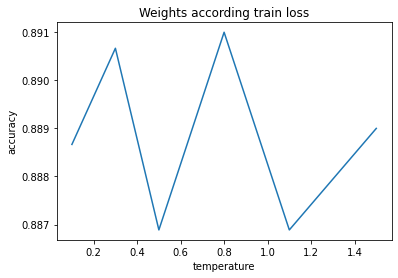

In [ ]:
plt.plot(temps, ens_accs)
plt.title('Weights according train loss')
plt.xlabel('temperature')
plt.ylabel('accuracy')
plt.show()

In [ ]:
#aacuracy of every one
for model in models_list:
  accuracy = []
  for (X_batch, y_batch) in testloader:
          y_batch = y_batch.cuda()
          logits = model(Variable(torch.FloatTensor(X_batch)).cuda())
          y_pred = logits.max(1)[1].data
          accuracy.append(np.mean((y_batch.cpu() == y_pred.cpu()).numpy() ))
  print(np.array(accuracy).mean() * 100, '%')

89.06666666666668 %
88.84444444444443 %
88.86666666666669 %
88.77777777777779 %
89.02222222222223 %
88.94444444444446 %
88.9 %
89.06666666666666 %
89.1 %
89.2 %
88.82222222222224 %
89.06666666666668 %
89.01111111111113 %
89.06666666666666 %
88.82222222222224 %
89.01111111111113 %
89.10000000000001 %
88.94444444444446 %
89.17777777777778 %
89.25555555555556 %
88.7888888888889 %
88.95555555555558 %
88.95555555555558 %
89.0777777777778 %
89.2888888888889 %
